# Feature Extraction

In this notebook, I will try to learn features of the radio images.

In [2]:
import sys

import keras.layers
import keras.models
import matplotlib.pyplot
import numpy
import scipy.ndimage.filters

sys.path.insert(1, '..')
import crowdastro.config
import crowdastro.data
import crowdastro.show

%matplotlib inline

NEIGHBOURHOOD_RADIUS = 20

In [4]:
input_shape = (1, NEIGHBOURHOOD_RADIUS * 2, NEIGHBOURHOOD_RADIUS * 2)
n_conv_filters = 100
conv_width = 4
hidden_dim = 256

In [17]:
model = keras.models.Sequential()

encoder = keras.models.Sequential()
encoder.add(keras.layers.Convolution2D(n_conv_filters, conv_width, conv_width, border_mode='valid', input_shape=input_shape))
encoder.add(keras.layers.Activation('relu'))
encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(keras.layers.Dropout(0.25))
encoder.add(keras.layers.Flatten())
encoder.add(keras.layers.Dense(hidden_dim))

decoder = keras.models.Sequential([
        keras.layers.Dense(hidden_dim * 2, input_shape=(hidden_dim,)),
        keras.layers.Dense(input_shape[1] * input_shape[2])
])

ae = keras.layers.AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=True)
model.add(ae)
model.compile(optimizer='sgd', loss='mse')

In [23]:
# Get some images, get some neighbourhoods, and hence find a training set.

def potential_hosts(subject, sigma=2, threshold=0.05):
    ir = crowdastro.data.get_ir(subject)

    neighborhood = numpy.ones((10, 10))
    blurred_ir = scipy.ndimage.filters.gaussian_filter(ir, sigma) > threshold
    local_max = scipy.ndimage.filters.maximum_filter(blurred_ir, footprint=neighborhood) == blurred_ir
    region_labels, n_labels = scipy.ndimage.measurements.label(local_max)
    maxima = numpy.array(
            [numpy.array((region_labels == i + 1).nonzero()).T.mean(axis=0)
             for i in range(n_labels)]
    )
    maxima = maxima[numpy.logical_and(maxima[:, 1] != 0, maxima[:, 1] != 499)]
    return maxima

training_inputs = []
training_outputs = []
n = 150
for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas'}).limit(n):
    hosts = potential_hosts(subject)
    
    ir = crowdastro.data.get_ir(subject)
    ir = numpy.pad(ir, NEIGHBOURHOOD_RADIUS, mode='constant')
    
    for host_y, host_x in hosts:
            ir_neighbourhood = ir[int(host_x) : int(host_x + 2 * NEIGHBOURHOOD_RADIUS),
                                  int(host_y) : int(host_y + 2 * NEIGHBOURHOOD_RADIUS)]
            training_inputs.append(ir_neighbourhood)
            training_outputs.append(ir_neighbourhood.flatten())

training_inputs = numpy.array(training_inputs)
training_outputs = numpy.array(training_outputs)

print('Found {} training inputs.'.format(len(training_inputs)))

Found 7092 training inputs.


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


In [24]:
training_inputs = training_inputs.reshape((training_inputs.shape[0], 1, training_inputs.shape[1], training_inputs.shape[2]))

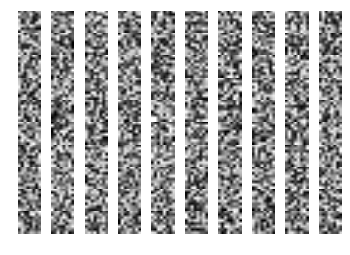

166
Epoch 1/1
 384/7092 [>.............................] - ETA: 115s - loss: 0.0636

KeyboardInterrupt: 

KeyboardInterrupt: 

In [28]:
import IPython.display

for i in range(200):
    print(i)
    model.fit(training_inputs, training_outputs, nb_epoch=1)
#     matplotlib.pyplot.figure(figsize=(15, 15))
    for i, kernel in enumerate(encoder.get_weights()[0]):
        kernel = kernel[0]
        matplotlib.pyplot.subplot(10, 10, i + 1)
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.imshow(kernel, cmap='gray')
        matplotlib.pyplot.subplots_adjust(hspace=0, wspace=0)
    IPython.display.clear_output(wait=True)
    IPython.display.display(matplotlib.pyplot.gcf())

[(100, 1, 8, 8), (100,), (40000, 256), (256,)]
ERROR! Session/line number was not unique in database. History logging moved to new session 99


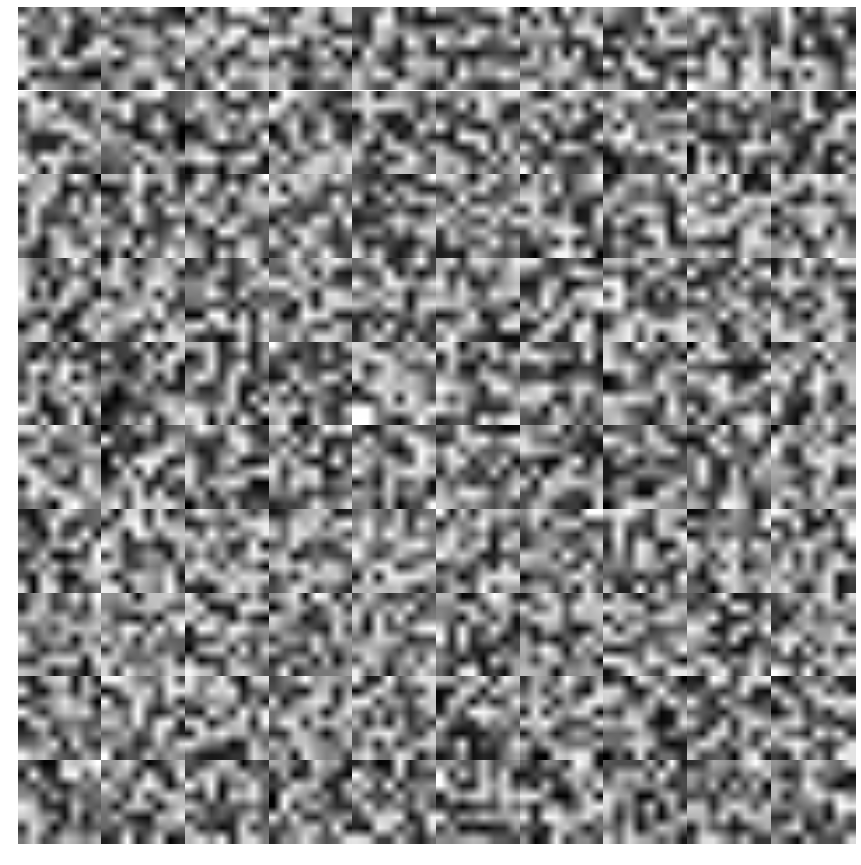

In [29]:
print([i.shape for i in encoder.get_weights()])
matplotlib.pyplot.figure(figsize=(15, 15))
for i, kernel in enumerate(encoder.get_weights()[0]):
    kernel = kernel[0]
    matplotlib.pyplot.subplot(10, 10, i + 1)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.imshow(kernel, cmap='gray')
    matplotlib.pyplot.subplots_adjust(hspace=0, wspace=0)
matplotlib.pyplot.show()

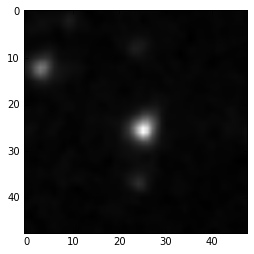

(1, 256)


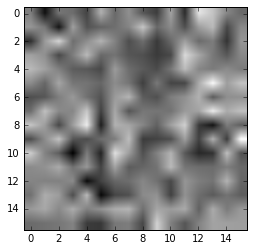

In [44]:
# crowdastro.show.image(training_inputs[:1, 0])
# matplotlib.pyplot.show()
encoder.compile(optimizer='sgd', loss='mse')
im = encoder.predict(training_inputs[:1])
matplotlib.pyplot.imshow(training_inputs[:1].reshape(48, 48), cmap='gray')
matplotlib.pyplot.show()
print(im.shape)
matplotlib.pyplot.imshow(im.reshape(16, 16), cmap='gray')
matplotlib.pyplot.show()

In [45]:
model.load_weights('features.h5')
model.save_weights('features.h5')

[WARNING] features.h5 already exists - overwrite? [y/n]n


In [49]:
encoder.save_weights('features_encoder.h5')